Figures for the paper: 

Dependencies (other than common ones):
- Experiments are run using `grid` https://github.com/mariogeiger/grid/tree/master/grid
- `diffeomorphism` https://github.com/pcsl-epfl/diffeomorphism

In [20]:
%load_ext autoreload
%autoreload 2
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
### Set GPU device ###
device = 'cuda'
%env CUDA_VISIBLE_DEVICES = 3

env: CUDA_VISIBLE_DEVICES=3


## CIFAR10: Roughness measures $D_f$, $G_f$ and Compression Ratio $R_f$

    python -m grid cifar-ps --n 10 "
    srun --nice --partition gpu --qos gpu --gres gpu:1 --time 24:00:00 --mem 10G
     python main.py --epochs 250 --onlydiffeo 0 --save_best_net 1 --save_dynamics 0 --diffeo 0
     " --batch_size 128 --net:str 'ResNet18' --dataset:str 'cifar10' --seed_init 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 --ptr 512 1024 2048 4096 8192 16384 32768 50000

In [69]:
filename = 'cifar_ps'

In [71]:
cuts = [3, 5, 15]
try:
    df = torch.load('./dataframes/res-net-roughness-df.torch')
except FileNotFoundError:
    df = pd.DataFrame()
    
predicate = lambda a: a.net == 'ResNet18' and a.seed_init >= 1 and a.random_crop == 1 and a.hflip == 1 and a.diffeo == 0 and a.ptr == 50000
runs = load(prefix + filename, predicate=predicate)
print(f'Loaded {len(runs)} runs')

for cut, interp in product(cuts, ['linear', 'gaussian']):
    
    imgs = load_cifar(p=500)
    imgs = imgs.to('cpu')
    n = imgs.shape[-1]
    T1, T2 = temperature_range(n, cut)
    Ts = torch.logspace(math.log10(T1 / 1.2), math.log10(T2 * 1.2), 30)
    data = diffeo_imgs(imgs, cuts=[cut], Ts=Ts, interp=interp)
    imgs = data['imgs'].to(device)

    print(interp)
    ds, gs = relative_distance(identity, data['imgs'].to(device), data['cuts'][0]['diffeo'].to(device), data['cuts'][0]['normal'].to(device))
    df = df.append({
        'ptr': 50000,
        'cut': cut,
        'Ts': data['cuts'][0]['temp'].numpy(),
        'layer': 'identity',
        'trained': 0,
        'interp': interp,
        'D': ds.to('cpu').numpy(),
        'G': gs.to('cpu').numpy(),
    }, ignore_index = True)
    
    for r in tqdm(runs):

        args = r['args']

        f = ResNet18()
        f = f.to(device)

        ### init ###
        ds, gs = relative_distance(f, imgs, data['cuts'][0]['diffeo'].to(device), data['cuts'][0]['normal'].to(device))
        df = df.append({
            'seed_init': args.seed_init,
            'ptr': args.ptr,
            'cut': cut,
            'Ts': data['cuts'][0]['temp'].numpy(),
            'layer': 'f',
            'trained': False,
            'acc': r['best']['acc'],
            'epoch': r['best']['epoch'],
            'interp': interp,
            'D': ds.to('cpu').numpy(),
            'G': gs.to('cpu').numpy(),
        }, ignore_index = True)

        ### TRAINED ###
        state = OrderedDict([(k[7:], r['best']['net'][k]) for k in r['best']['net']])
        f.load_state_dict(state)
        ds, gs = relative_distance(f, imgs, data['cuts'][0]['diffeo'].to(device), data['cuts'][0]['normal'].to(device))

        df = df.append({
            'seed_init': args.seed_init,
            'ptr': args.ptr,
            'cut': cut,
            'Ts': data['cuts'][0]['temp'].numpy(),
            'layer': 'f',
            'trained': True,
            'acc': r['best']['acc'],
            'epoch': r['best']['epoch'],
            'interp': interp,
            'D': ds.to('cpu').numpy(),
            'G': gs.to('cpu').numpy(),
        }, ignore_index = True)


100%|██████████| 732/732 [00:16<00:00, 43.22it/s]


Loaded 19 runs
Files already downloaded and verified



linear



Files already downloaded and verified



gaussian



Files already downloaded and verified



linear



Files already downloaded and verified



gaussian



Files already downloaded and verified



linear



Files already downloaded and verified



gaussian


In [33]:
groups = ['cut', 'layer', 'trained', 'interp']

df['R'] = df['D'] / df['G']
D = df.groupby(groups)['D'].apply(logmean)
G = df.groupby(groups)['G'].apply(logmean)
R = df.groupby(groups)['R'].apply(logmean)
acc = df.groupby(groups)['acc'].apply(partial(logmean, vec=False))
epoch = df.groupby(groups)['epoch'].apply(partial(logmean, vec=False))

<IPython.core.display.Javascript object>


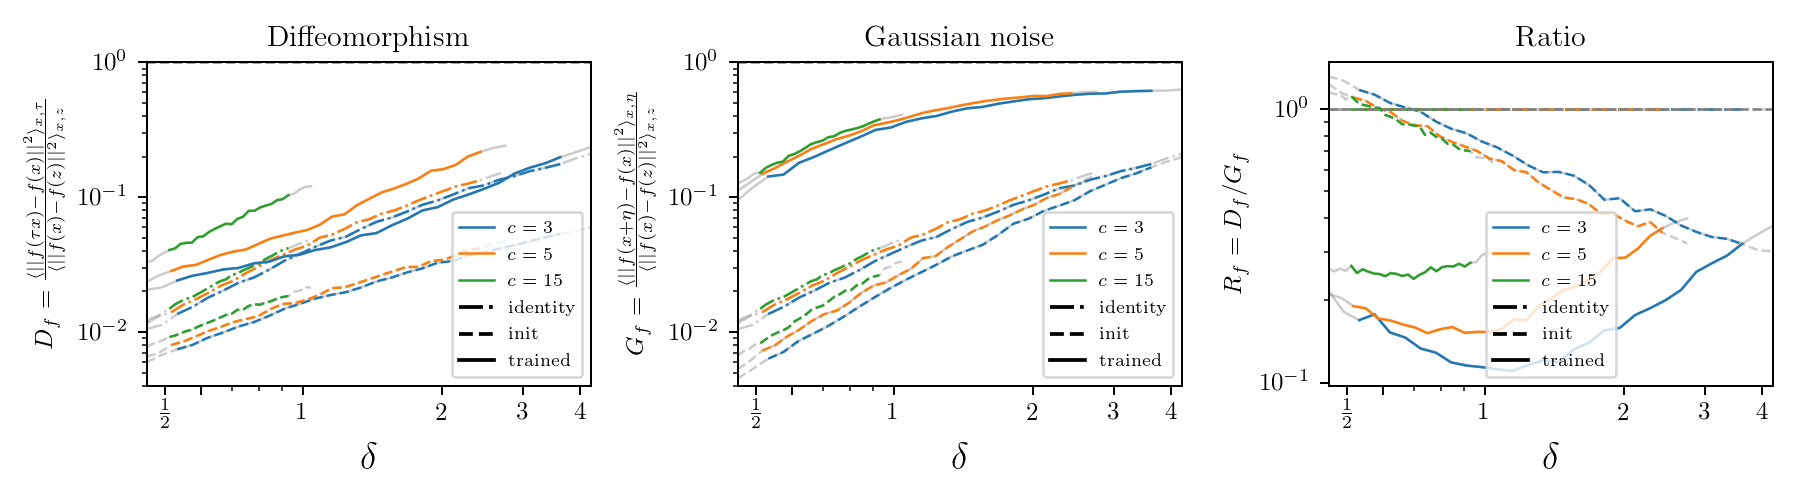

In [82]:
%matplotlib notebook
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(10, 2.8), dpi=180)
alpha = 0.4

for cut in cuts:
    T1, T2 = temperature_range(n, cut)
    Ts = torch.logspace(math.log10(T1 / greyTrate), math.log10(T2 * greyTrate), 30)
    m = (T1 <= Ts) & (Ts <= T2)
    delta = typical_displacement(Ts, cut)
    if cut == 3:
        d3 = copy.deepcopy(delta)
        
    ds, qs = D[cut]['identity'][0]['linear'], G[cut]['identity'][0]['linear']

    plt.sca(ax1)
    plt.plot(delta, ds, '-.', color='gray', alpha = alpha, lw=1)
    plt.plot(delta[m], ds[m], '-.', lw=1)

    plt.sca(ax2)
    plt.plot(delta, qs, '-.', color='gray', alpha = alpha, lw=1)
    plt.plot(delta[m], qs[m], '-.', lw=1)

    plt.sca(ax3)
    plt.plot(delta, ds/qs, '-.', color='gray', alpha = alpha, lw=1)
    plt.plot(delta[m], (ds/qs)[m], '-.', lw=1)
        
        
for trained in [1, 0]:
    for ax in [ax1, ax2, ax3]:
        ax.set_prop_cycle(None)

    for cut in cuts:
        T1, T2 = temperature_range(n, cut)
        Ts = torch.logspace(math.log10(T1 / greyTrate), math.log10(T2 * greyTrate), 30)
        m = (T1 <= Ts) & (Ts <= T2)
        delta = typical_displacement(Ts, cut)

        ds, qs = D[cut]['f'][trained]['linear'], G[cut]['f'][trained]['linear']
        
        if trained:
            label = f'$c = {cut}$'
        else:
            label = None
        
        plt.sca(ax1)
        plt.plot(delta, ds, '-' if trained else '--', color='gray', alpha = alpha, lw=1)
        plt.plot(delta[m], ds[m], '-' if trained else '--', label=label , lw=1)

        plt.sca(ax2)
        plt.plot(delta, qs, '-' if trained else '--', color='gray', alpha = alpha, lw=1)
        plt.plot(delta[m], qs[m], '-' if trained else '--', label=label , lw=1)

        plt.sca(ax3)
        plt.plot(delta, ds/qs, '-' if trained else '--', color='gray', alpha = alpha, lw=1)
        plt.plot(delta[m], (ds/qs)[m], '-' if trained else '--', label=label, lw=1)


for ax in [ax1, ax2, ax3]:
    plt.sca(ax)
    plt.plot([], [], 'k-.', label='identity')
    plt.plot([], [], 'k--', label='init')
    plt.plot([], [], 'k-', label='trained')

    plt.plot(plt.xlim(), [1, 1], '--', color='gray', linewidth=1)

    plt.legend(fontsize=7)
    plt.xscale('log')
    plt.yscale('log')
    
    plt.xlim(d3[0], d3[-1])
    plt.xlabel(r'$\delta$', fontsize=15)
    
    plt.xticks([0.5, 0.6, 1, 2, 3, 4], [r'$\frac{1}{2}$', '', 1, 2, 3, 4])
    
plt.sca(ax1)    
plt.ylabel(r'$D_f = \frac{\langle ||f(\tau x) - f(x)||^2\rangle_{x, \tau}}{\langle ||f(x) - f(z)||^2\rangle_{x, z}}$')
plt.title('Diffeomorphism')
plt.sca(ax2)
plt.ylabel(r'$    G_f = \frac{\langle ||f(x + \eta) - f(x)||^2\rangle_{x, \eta}}{\langle ||f(x) - f(z)||^2\rangle_{x, z}}$')
plt.title('Gaussian noise')
plt.sca(ax3)
plt.ylabel(r'$R_f = D_f / G_f$')
plt.title('Ratio')

for ax in [ax1, ax2]:
    plt.sca(ax)
    plt.ylim(4e-3, 1.01)
    
plt.tight_layout()
plt.savefig('./figures/cifar_resnet_roughness.pdf', format='pdf')

### Compression ratio $\mathcal R(p)$ for $\delta = 1$

In [92]:
try:
    df = torch.load('./dataframes/res-net-df.torch')
except FileNotFoundError:
    df = pd.DataFrame()
    
for dataset in ['mnist', 'fashionmnist']:
    if 'mnist' in dataset:
        filename = 'f-mnist_ps'
        predicate = lambda a: a.dataset == dataset and a.ptr == 50000 # and ((a.batch_size >= 128 and a.ptr >= 512) or (a.batch_size == 32 and a.ptr <= 512))
        cut = 3
        ch = 1
    else:
        filename = 'cifar_ps'
        predicate = lambda a: a.seed_init >= 1 and a.random_crop == 1 and a.hflip == 1 and a.diffeo == 0 and a.ptr > 32 and ((a.batch_size >= 128 and a.ptr >= 512) or (a.batch_size == 32 and a.ptr <= 512))
        cut = 5
        ch = 3
        
    runs = load(prefix + filename, predicate=predicate)
    print(f'Loaded {len(runs)} runs')

    for interp in ['linear', 'gaussian']:
        if 'mnist' in dataset:
            imgs = load_mnist(p=500, fashion= 'fashion' in dataset)
        else:
            imgs = load_cifar(p=500)
        n = imgs.shape[-1]    
        imgs = imgs.to('cpu')
        T1, T2 = temperature_range(n, cut)
        Ts = typical_temperature(delta=torch.ones(1,), cut=cut)
        data = diffeo_imgs(imgs, cuts=[cut], Ts=Ts, interp=interp)
        imgs = data['imgs'].to(device)

        print(interp)

        for r in tqdm(runs):

            args = r['args']
            f = ResNet18(num_ch=ch)
            f.eval()
            f = f.to(device)
            state = OrderedDict([(k[7:], r['best']['net'][k]) for k in r['best']['net']])
            f.load_state_dict(state)

            rs = computeR(f, imgs, data['cuts'][0]['diffeo'].to(device), data['cuts'][0]['normal'].to(device))

            df = df.append({
                'dataset': dataset,
                'seed_init': args.seed_init,
                'ptr': args.ptr,
                'cut': cut,
                'Ts': data['cuts'][0]['temp'].numpy(),
                'layer': 'f',
                'trained': True,
                'acc': r['best']['acc'],
                'epoch': r['best']['epoch'],
                'interp': interp,
                'R': rs.to('cpu').numpy(),
            }, ignore_index = True)



  0%|          | 0/544 [00:00<?, ?it/s]

  0%|          | 2/544 [00:00<00:27, 19.87it/s]

  1%|          | 5/544 [00:00<00:25, 21.50it/s]

  1%|▏         | 8/544 [00:00<00:23, 22.58it/s]

  2%|▏         | 11/544 [00:00<00:22, 23.55it/s]

  3%|▎         | 14/544 [00:00<00:22, 23.63it/s]

  3%|▎         | 17/544 [00:00<00:23, 22.76it/s]

  4%|▎         | 20/544 [00:01<00:42, 12.27it/s]

  4%|▍         | 22/544 [00:01<00:37, 13.74it/s]

  5%|▍         | 25/544 [00:01<00:33, 15.51it/s]

  5%|▍         | 27/544 [00:01<00:58,  8.89it/s]

  6%|▌         | 30/544 [00:02<00:47, 10.89it/s]

  6%|▌         | 33/544 [00:02<00:39, 13.02it/s]

  7%|▋         | 36/544 [00:02<00:33, 15.08it/s]

  7%|▋         | 39/544 [00:02<00:32, 15.61it/s]

  8%|▊         | 41/544 [00:02<00:31, 16.15it/s]

  8%|▊         | 44/544 [00:02<00:27, 18.47it/s]

  9%|▊         | 47/544 [00:02<00:24, 20.38it/s]

  9%|▉         | 50/544 [00:03<00:28, 17.61it/s]

 10%|▉         | 53/544 [00:03<00:26, 18.66it/s]

 10%|█    

Loaded 16 runs



linear



gaussian




  0%|          | 0/544 [00:00<?, ?it/s]

 15%|█▍        | 79/544 [00:00<00:00, 780.58it/s]



 20%|█▉        | 108/544 [00:00<00:02, 181.81it/s]

 26%|██▋       | 144/544 [00:01<00:03, 129.18it/s]

 34%|███▍      | 184/544 [00:01<00:03, 111.93it/s]

 44%|████▍     | 238/544 [00:01<00:02, 110.87it/s]

 50%|█████     | 272/544 [00:02<00:01, 138.52it/s]

 56%|█████▋    | 306/544 [00:02<00:01, 168.46it/s]

 65%|██████▌   | 355/544 [00:02<00:00, 209.75it/s]

 71%|███████   | 386/544 [00:02<00:01, 126.44it/s]

 75%|███████▌  | 410/544 [00:03<00:01, 91.47it/s] 

 87%|████████▋ | 475/544 [00:03<00:00, 123.13it/s]

100%|██████████| 544/544 [00:03<00:00, 159.47it/s]

Loaded 6 runs



linear



gaussian


In [94]:
torch.save(df, './dataframes/res-net-df.torch')

In [95]:
groups = ['dataset', 'cut', 'interp', 'ptr']
R = df.groupby(groups)['R'].apply(logmean)
acc = df.groupby(groups)['acc'].apply(partial(logmean, vec=False))
epoch = df.groupby(groups)['epoch'].apply(partial(logmean, vec=False))

In [96]:
torch.save({
    'R': R,
    'acc': acc
}, './dataframes/res-net-R.torch')

<IPython.core.display.Javascript object>


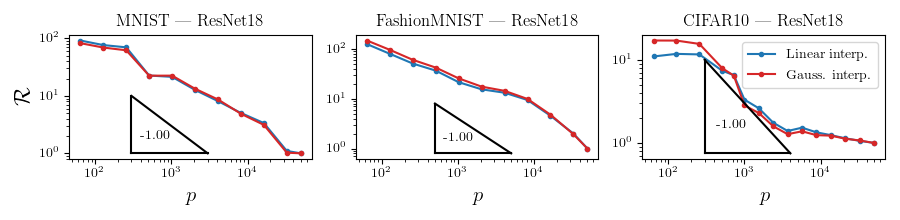

<ipython-input-108-13252b5816f0>:34: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([pa, pb], labels=['Linear interp.', 'Gauss. interp.'])


In [108]:
%matplotlib notebook
fig, ax = plt.subplots(1, 3, figsize=(9, 2.2))
pmax = df['ptr'].unique().max()
for di, dataset in enumerate(['mnist', 'fashionmnist', 'cifar10']):
    cut = 3 if 'mnist' in dataset else 5
    plt.sca(ax[di])
    for interp in ['linear', 'gaussian']:

        cs = 'C0' if interp == 'linear' else 'C3'
        
        if dataset == 'mnist':
            dataname = 'MNIST'
        if dataset == 'fashionmnist':
            dataname = 'FashionMNIST'
        if dataset == 'cifar10':
            dataname = 'CIFAR10'
        plt.title(f'{dataname} | ResNet18')
        R[dataset][cut][interp].apply(lambda a: a[0] / R[dataset][cut][interp][pmax][0]).plot(marker='.', c=cs)
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('$p$', fontsize=15)
        plt.tight_layout()
        
plt.sca(ax[0])
plt.ylabel(r'$\mathcal R$', fontsize=16)
triangle(300, 3e3, 10, slope=-1)
plt.tight_layout()
plt.sca(ax[1]) 
triangle(5e2, 5e3, 8, slope=-1)
plt.sca(ax[2])        
triangle(300, 4e3, 10, slope=-1)
pa = plt.plot([], [], c='C0', label='Linear interp.')
pb = plt.plot([], [], c='C3', label='Gauss. interp.')
plt.legend([pa, pb], labels=['Linear interp.', 'Gauss. interp.'])

plt.savefig('./figures/compression_ratio_cifar.pdf', format='pdf')

<IPython.core.display.Javascript object>


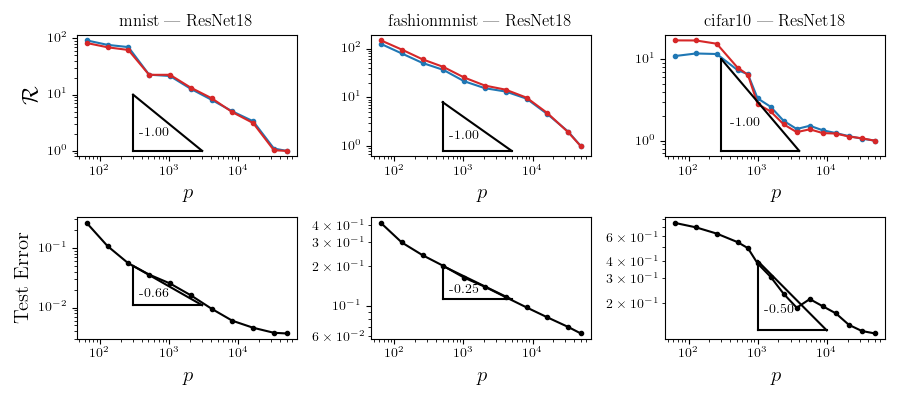

-0.5

In [100]:
%matplotlib notebook
fig, ax = plt.subplots(2, 3, figsize=(9, 4))
pmax = df['ptr'].unique().max()
for di, dataset in enumerate(['mnist', 'fashionmnist', 'cifar10']):
    cut = 3 if 'mnist' in dataset else 5
    plt.sca(ax[0, di])
    for interp in ['linear', 'gaussian']:

        cs = 'C0' if interp == 'linear' else 'C3'

        plt.title(f'{dataset} | ResNet18')
        R[dataset][cut][interp].apply(lambda a: a[0] / R[dataset][cut][interp][pmax][0]).plot(marker='.', c=cs)
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('$p$', fontsize=15)
        plt.tight_layout()

    plt.sca(ax[1, di])

    acc[dataset][cut][interp].apply(lambda a: 1 - a / 100).plot(marker='.', c='k')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('$p$', fontsize=15)
    plt.tight_layout()
        
plt.sca(ax[0, 0])
plt.ylabel(r'$\mathcal R$', fontsize=16)
triangle(300, 3e3, 10, slope=-1)
plt.tight_layout()
plt.sca(ax[0, 1])        
triangle(5e2, 5e3, 8, slope=-1)
plt.sca(ax[0, 2])        
triangle(300, 4e3, 10, slope=-1)

plt.sca(ax[1, 0])
plt.ylabel(r'Test Error', fontsize=15)
triangle(300, 3e3, 5e-2, slope=-0.66)
plt.tight_layout()
plt.sca(ax[1, 1])        
triangle(5e2, 5e3, 2e-1, slope=-.25)
plt.sca(ax[1, 2])        
triangle(1e3, 1e4, 4e-1, slope=-.5)


# EfficientNetB0

    python -m grid efficientnetb0 --n 20 "
    srun --nice --partition gpu --qos gpu --gres gpu:1 --time 24:00:00 --mem 10G
     python main.py --epochs 250 --onlydiffeo 0 --save_best_net 1 --save_dynamics 0 --diffeo 0
     " --batch_size 128 --net:str 'EfficientNetB0' --dataset:str 'mnist' 'fashionmnist' 'cifar10' --seed_init 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 --ptr 512 1024 2048 4096 8192 16384 32768 50000

In [97]:
filename = 'efficientnetb0'

In [98]:
cuts = [3, 5, 15]
greyTrate = 1.2
try:
    df = torch.load('./dataframes/eff-net-roughness-df.torch')
except FileNotFoundError:
    df = pd.DataFrame()

for interp in ['linear', 'gaussian']:
    for dataset in ['mnist', 'fashionmnist', 'cifar10']:
        predicate = lambda a: a.dataset == dataset and a.ptr == 50000
        runs = load(prefix + filename, predicate=predicate)
        print(f'Loaded {len(runs)} runs')

        for cut in cuts:
        # interp = 'gaussian'
            if 'mnist' in dataset:
                ch = 1
                imgs = load_mnist(p=500, fashion= 'fashion' in dataset)
            else:
                ch = 3
                imgs = load_cifar(p=800)

            n = imgs.shape[-1]
            imgs = imgs.to('cpu')
            T1, T2 = temperature_range(n, cut)
            Ts = torch.logspace(math.log10(T1 / greyTrate), math.log10(T2 * greyTrate), 30)
            data = diffeo_imgs(imgs, cuts=[cut], Ts=Ts, interp=interp)
            imgs = data['imgs'].to(device)

            print(interp)

            ds, gs = relative_distance(identity, data['imgs'].to(device), data['cuts'][0]['diffeo'].to(device), data['cuts'][0]['normal'].to(device))
            df = df.append({
                'dataset': dataset,
                'cut': cut,
                'ptr': 50000,
                'Ts': data['cuts'][0]['temp'].numpy(),
                'layer': 'identity',
                'trained': 0,
                'interp': interp,
                'D': ds.to('cpu').numpy(),
                'G': gs.to('cpu').numpy(),
            }, ignore_index = True)

            for r in tqdm(runs):

                args = r['args']

                f = EfficientNetB0(num_ch=ch)
                f = f.to(device)

                ### init ###
                try:
                    ds, gs = relative_distance(f, imgs, data['cuts'][0]['diffeo'].to(device), data['cuts'][0]['normal'].to(device))
                    df = df.append({
                        'dataset': dataset,
                        'seed_init': args.seed_init,
                        'ptr': args.ptr,
                        'cut': cut,
                        'Ts': data['cuts'][0]['temp'].numpy(),
                        'layer': 'f',
                        'trained': False,
                        'acc': r['best']['acc'],
                        'epoch': r['best']['epoch'],
                        'interp': interp,
                        'D': ds.to('cpu').numpy(),
                        'G': gs.to('cpu').numpy(),
                    }, ignore_index = True)

                    ### TRAINED ###
                    state = OrderedDict([(k[7:], r['best']['net'][k]) for k in r['best']['net']])
                    f.load_state_dict(state)
                    ds, gs = relative_distance(f, imgs, data['cuts'][0]['diffeo'].to(device), data['cuts'][0]['normal'].to(device))

                    df = df.append({
                        'dataset': dataset,
                        'seed_init': args.seed_init,
                        'ptr': args.ptr,
                        'cut': cut,
                        'Ts': data['cuts'][0]['temp'].numpy(),
                        'layer': 'f',
                        'trained': True,
                        'acc': r['best']['acc'],
                        'epoch': r['best']['epoch'],
                        'interp': interp,
                        'D': ds.to('cpu').numpy(),
                        'G': gs.to('cpu').numpy(),
                    }, ignore_index = True)
                except ZeroDivisionError:
                    continue


100%|██████████| 528/528 [00:00<00:00, 605.06it/s]

Loaded 16 runs



linear



linear



linear



 23%|██▎       | 122/528 [00:00<00:00, 1217.33it/s]


100%|██████████| 528/528 [00:00<00:00, 786.90it/s]

Loaded 16 runs



linear



linear



linear



 26%|██▋       | 139/528 [00:00<00:00, 1389.57it/s]


100%|██████████| 528/528 [00:00<00:00, 1006.80it/s]


Loaded 16 runs
Files already downloaded and verified



linear



Files already downloaded and verified



linear



Files already downloaded and verified



linear



 19%|█▊        | 98/528 [00:00<00:00, 979.82it/s]


100%|██████████| 528/528 [00:00<00:00, 842.20it/s]

Loaded 16 runs



gaussian



gaussian



 16%|█▋        | 86/528 [00:00<00:00, 853.68it/s]


100%|██████████| 528/528 [00:00<00:00, 776.12it/s]

Loaded 16 runs



gaussian



gaussian



gaussian



 20%|█▉        | 103/528 [00:00<00:00, 1022.75it/s]


100%|██████████| 528/528 [00:00<00:00, 572.75it/s]


Loaded 16 runs
Files already downloaded and verified



gaussian



Files already downloaded and verified



gaussian



Files already downloaded and verified



gaussian


In [82]:
torch.save(df, './dataframes/eff-net-roughness-df.torch')

In [77]:
df = torch.load('./dataframes/eff-net-roughness-df.torch')

In [85]:
groups = ['dataset', 'cut', 'layer', 'trained', 'interp']

df['R'] = df['D'] / df['G']
D = df.groupby(groups)['D'].apply(logmean)
G = df.groupby(groups)['G'].apply(logmean)
R = df.groupby(groups)['R'].apply(logmean)
acc = df.groupby(groups)['acc'].apply(partial(logmean, vec=False))
epoch = df.groupby(groups)['epoch'].apply(partial(logmean, vec=False))

In [86]:
datasets = ['mnist', 'fashionmnist', 'cifar10']

<IPython.core.display.Javascript object>


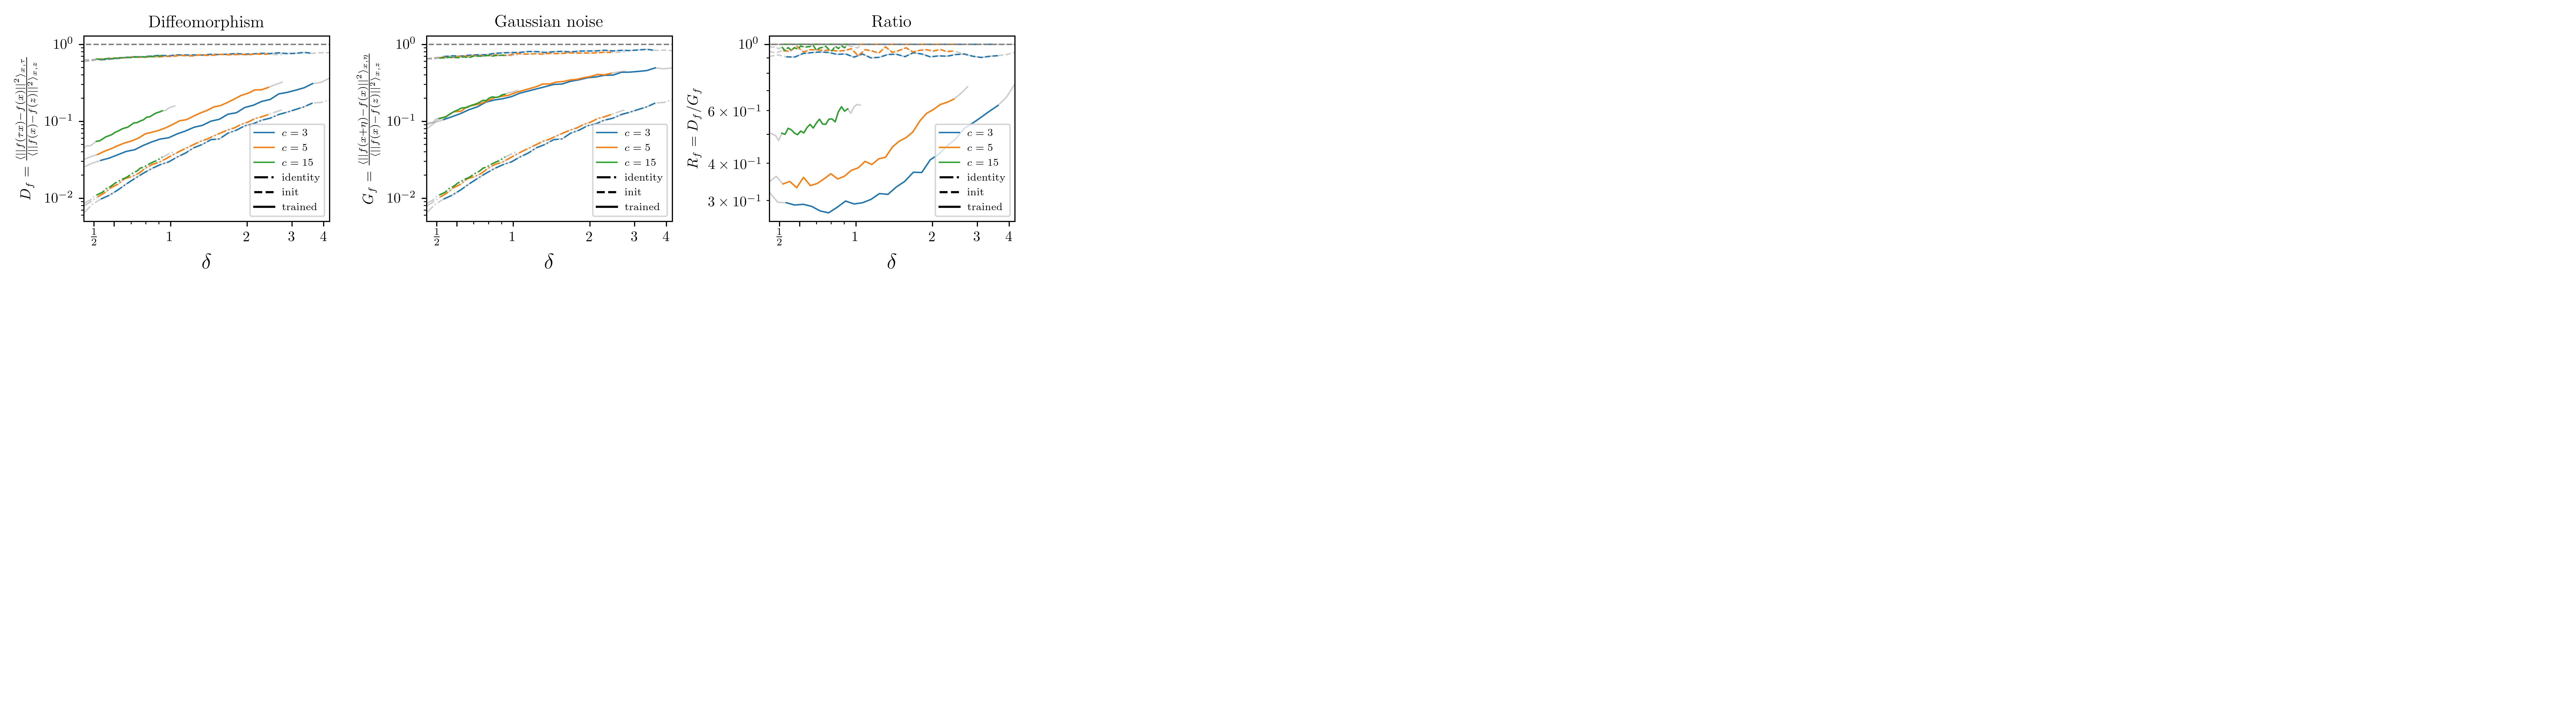

In [88]:
%matplotlib notebook
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(10, 2.8), dpi=180)
alpha = 0.4

interp = 'gaussian'

for (di, dataset), cut in product(enumerate(['cifar10']), cuts):
    T1, T2 = temperature_range(n, cut)
    Ts = torch.logspace(math.log10(T1 / greyTrate), math.log10(T2 * greyTrate), 30)
    m = (T1 <= Ts) & (Ts <= T2)
    delta = typical_displacement(Ts, cut)
    if cut == 3:
        d3 = copy.deepcopy(delta)
        
    ds, qs = D[dataset][cut]['identity'][0][interp], G[dataset][cut]['identity'][0][interp]

    plt.sca(ax1)
    plt.plot(delta, ds, '-.', color='gray', alpha = alpha, lw=1)
    plt.plot(delta[m], ds[m], '-.', lw=1)

    plt.sca(ax2)
    plt.plot(delta, qs, '-.', color='gray', alpha = alpha, lw=1)
    plt.plot(delta[m], qs[m], '-.', lw=1)

    plt.sca(ax3)
    plt.plot(delta, ds/qs, '-.', color='gray', alpha = alpha, lw=1)
    plt.plot(delta[m], (ds/qs)[m], '-.', lw=1)
        
        
for trained in [1, 0]:
    for ax in [ax1, ax2, ax3]:
        ax.set_prop_cycle(None)

    for cut in cuts:
        T1, T2 = temperature_range(n, cut)
        Ts = torch.logspace(math.log10(T1 / greyTrate), math.log10(T2 * greyTrate), 30)
        m = (T1 <= Ts) & (Ts <= T2)
        delta = typical_displacement(Ts, cut)

        ds, qs = D[dataset][cut]['f'][trained][interp], G[dataset][cut]['f'][trained][interp]
        
        if trained:
            label = f'$c = {cut}$'
        else:
            label = None
        
        plt.sca(ax1)
        plt.plot(delta, ds, '-' if trained else '--', color='gray', alpha = alpha, lw=1)
        plt.plot(delta[m], ds[m], '-' if trained else '--', label=label , lw=1)

        plt.sca(ax2)
        plt.plot(delta, qs, '-' if trained else '--', color='gray', alpha = alpha, lw=1)
        plt.plot(delta[m], qs[m], '-' if trained else '--', label=label , lw=1)

        plt.sca(ax3)
        plt.plot(delta, ds/qs, '-' if trained else '--', color='gray', alpha = alpha, lw=1)
        plt.plot(delta[m], (ds/qs)[m], '-' if trained else '--', label=label, lw=1)


for ax in [ax1, ax2, ax3]:
    plt.sca(ax)
    plt.plot([], [], 'k-.', label='identity')
    plt.plot([], [], 'k--', label='init')
    plt.plot([], [], 'k-', label='trained')

    plt.plot(plt.xlim(), [1, 1], '--', color='gray', linewidth=1)

    plt.legend(fontsize=7)
    plt.xscale('log')
    plt.yscale('log')

    plt.xlim(d3[0], d3[-1])
    plt.xlabel(r'$\delta$', fontsize=15)

    plt.xticks([0.5, 0.6, 1, 2, 3, 4], [r'$\frac{1}{2}$', '', 1, 2, 3, 4])
    
plt.sca(ax1)    
plt.ylabel(r'$D_f = \frac{\langle ||f(\tau x) - f(x)||^2\rangle_{x, \tau}}{\langle ||f(x) - f(z)||^2\rangle_{x, z}}$')
plt.title('Diffeomorphism')
plt.sca(ax2)
plt.ylabel(r'$    G_f = \frac{\langle ||f(x + \eta) - f(x)||^2\rangle_{x, \eta}}{\langle ||f(x) - f(z)||^2\rangle_{x, z}}$')
plt.title('Gaussian noise')
plt.sca(ax3)
plt.ylabel(r'$R_f = D_f / G_f$')
plt.title('Ratio')


# plt.sca(ax1)
# triangle(0.5, 5, 2e-4, slope=1)
# plt.sca(ax2)
# triangle(0.5, 5, 1e-4, slope=2)

for ax in [ax1, ax2]:
    plt.sca(ax)
#     plt.ylim(4e-3, 1.01)
    
plt.tight_layout()
# plt.suptitle('EfficientNetB0 on CIFAR10', y=.99)
# plt.savefig('./figures/cifar_effnet_roughness.pdf', format='pdf')

<IPython.core.display.Javascript object>


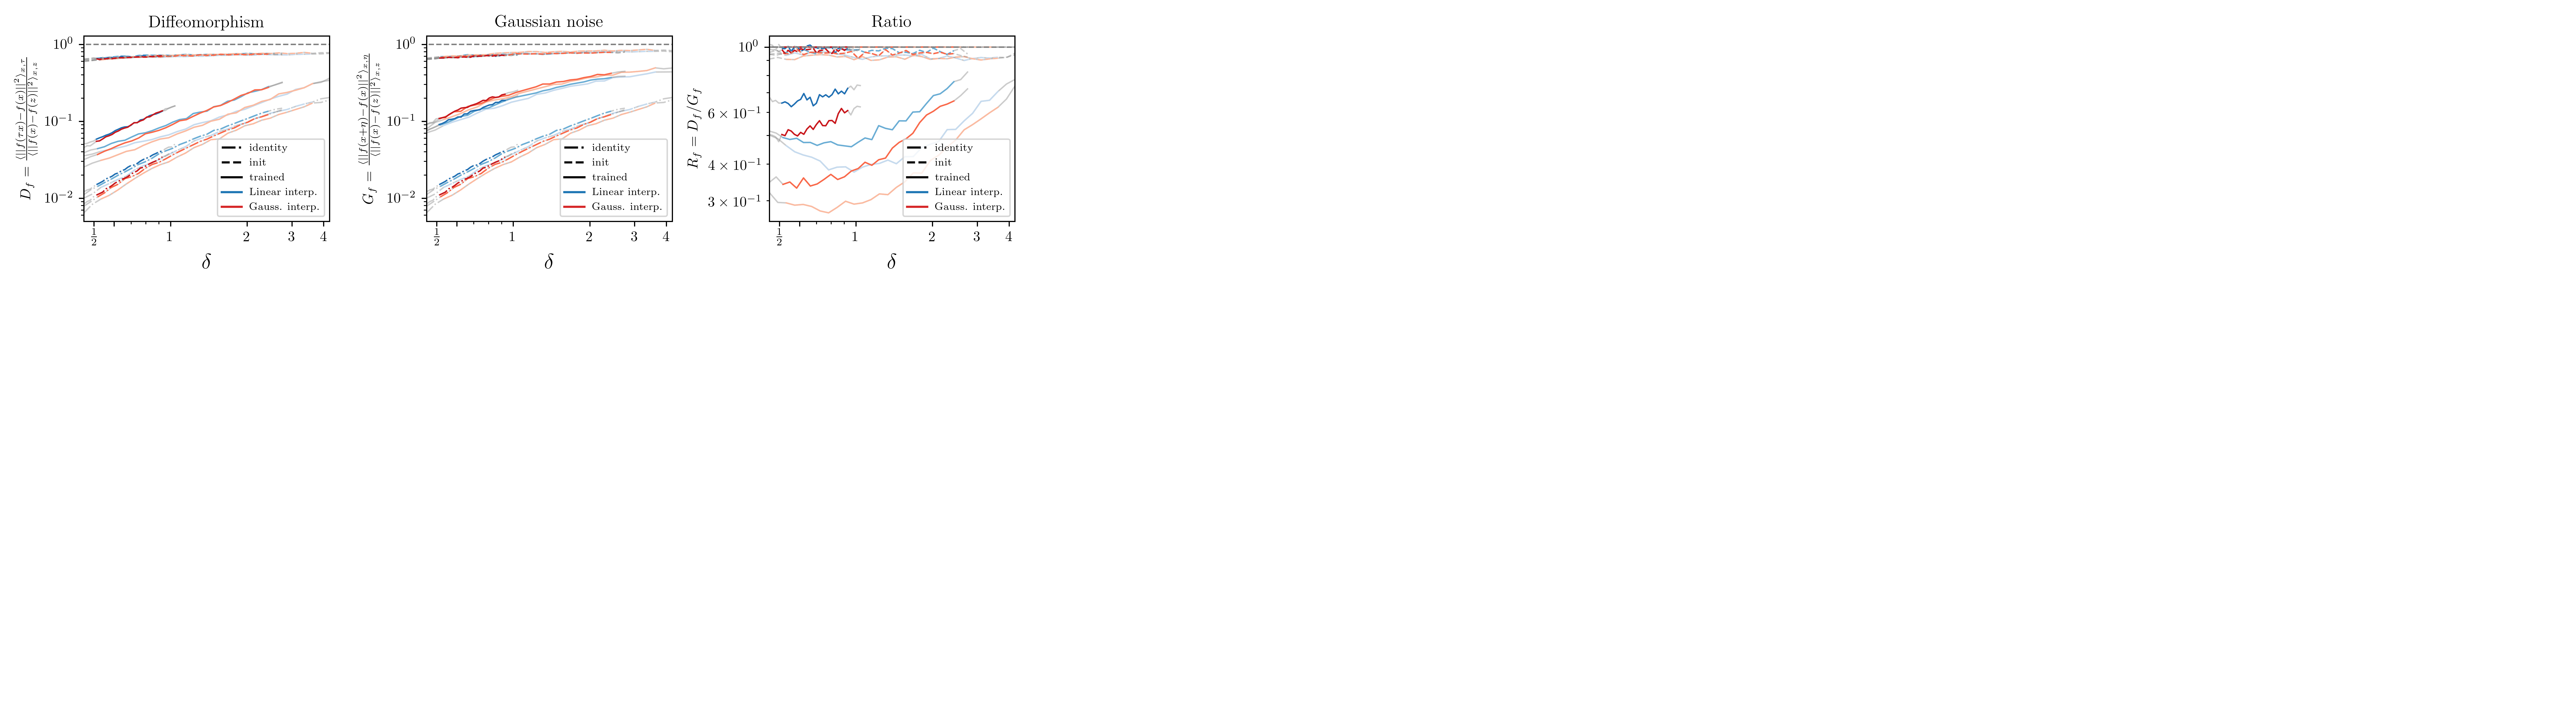

<ipython-input-95-20e3d810f038>:73: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([pa, pb], labels=['Linear interp.', 'Gauss. interp.'])
<ipython-input-95-20e3d810f038>:73: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([pa, pb], labels=['Linear interp.', 'Gauss. interp.'])
<ipython-input-95-20e3d810f038>:73: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([pa, pb], labels=['Linear interp.', 'Gauss. interp.'])


In [95]:
%matplotlib notebook
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(10, 2.8), dpi=180)
alpha = 0.4

nc = 3 # Number of colors
bcs = [plt.get_cmap('Blues')((i+1)/(nc+1)) for i in range(nc)]
rcs = [plt.get_cmap('Reds')((i+1)/(nc+1)) for i in range(nc)]

for interp in ['linear', 'gaussian']:
    
    cs = bcs if interp == 'linear' else rcs
    
    for (di, dataset), (ci, cut) in product(enumerate(['cifar10']), enumerate(cuts)):
        T1, T2 = temperature_range(n, cut)
        Ts = torch.logspace(math.log10(T1 / greyTrate), math.log10(T2 * greyTrate), 30)
        m = (T1 <= Ts) & (Ts <= T2)
        delta = typical_displacement(Ts, cut)
        if cut == 3:
            d3 = copy.deepcopy(delta)

        ds, qs = D[dataset][cut]['identity'][0][interp], G[dataset][cut]['identity'][0][interp]

        plt.sca(ax1)
        plt.plot(delta, ds, '-.', color='gray', alpha = alpha, lw=1)
        plt.plot(delta[m], ds[m], '-.', lw=1, c=cs[ci])

        plt.sca(ax2)
        plt.plot(delta, qs, '-.', color='gray', alpha = alpha, lw=1)
        plt.plot(delta[m], qs[m], '-.', lw=1, c=cs[ci])

        plt.sca(ax3)
        plt.plot(delta, ds/qs, '-.', color='gray', alpha = alpha, lw=1)
        plt.plot(delta[m], (ds/qs)[m], '-.', lw=1, c=cs[ci])


    for trained in [1, 0]:
        for ax in [ax1, ax2, ax3]:
            ax.set_prop_cycle(None)

        for ci, cut in enumerate(cuts):
            T1, T2 = temperature_range(n, cut)
            Ts = torch.logspace(math.log10(T1 / greyTrate), math.log10(T2 * greyTrate), 30)
            m = (T1 <= Ts) & (Ts <= T2)
            delta = typical_displacement(Ts, cut)

            ds, qs = D[dataset][cut]['f'][trained][interp], G[dataset][cut]['f'][trained][interp]

            if 0:
                label = f'$c = {cut}$'
            else:
                label = None

            plt.sca(ax1)
            plt.plot(delta, ds, '-' if trained else '--', color='gray', alpha = alpha, lw=1)
            plt.plot(delta[m], ds[m], '-' if trained else '--', label=label , lw=1, c=cs[ci])

            plt.sca(ax2)
            plt.plot(delta, qs, '-' if trained else '--', color='gray', alpha = alpha, lw=1)
            plt.plot(delta[m], qs[m], '-' if trained else '--', label=label , lw=1, c=cs[ci])

            plt.sca(ax3)
            plt.plot(delta, ds/qs, '-' if trained else '--', color='gray', alpha = alpha, lw=1)
            plt.plot(delta[m], (ds/qs)[m], '-' if trained else '--', label=label, lw=1, c=cs[ci])


for ax in [ax1, ax2, ax3]:
    plt.sca(ax)
    plt.plot([], [], 'k-.', label='identity')
    plt.plot([], [], 'k--', label='init')
    plt.plot([], [], 'k-', label='trained')
    pa = plt.plot([], [], c='C0', label='Linear interp.')
    pb = plt.plot([], [], c='C3', label='Gauss. interp.')
    plt.legend([pa, pb], labels=['Linear interp.', 'Gauss. interp.'])
    plt.plot(plt.xlim(), [1, 1], '--', color='gray', linewidth=1)

    plt.legend(fontsize=7)
    plt.xscale('log')
    plt.yscale('log')

    plt.xlim(d3[0], d3[-1])
    plt.xlabel(r'$\delta$', fontsize=15)

    plt.xticks([0.5, 0.6, 1, 2, 3, 4], [r'$\frac{1}{2}$', '', 1, 2, 3, 4])
    
plt.sca(ax1)    
plt.ylabel(r'$D_f = \frac{\langle ||f(\tau x) - f(x)||^2\rangle_{x, \tau}}{\langle ||f(x) - f(z)||^2\rangle_{x, z}}$')
plt.title('Diffeomorphism')
plt.sca(ax2)
plt.ylabel(r'$    G_f = \frac{\langle ||f(x + \eta) - f(x)||^2\rangle_{x, \eta}}{\langle ||f(x) - f(z)||^2\rangle_{x, z}}$')
plt.title('Gaussian noise')
plt.sca(ax3)
plt.ylabel(r'$R_f = D_f / G_f$')
plt.title('Ratio')


# plt.sca(ax1)
# triangle(0.5, 5, 2e-4, slope=1)
# plt.sca(ax2)
# triangle(0.5, 5, 1e-4, slope=2)

for ax in [ax1, ax2]:
    plt.sca(ax)
#     plt.ylim(4e-3, 1.01)
    
plt.tight_layout()
# plt.suptitle('EfficientNetB0 on CIFAR10', y=.99)
plt.savefig('./figures/cifar_effnet_roughness_interp.pdf', format='pdf')

$\mathcal R$

In [35]:
filename = 'efficientnetb0'
try:
    df = torch.load('./dataframes/eff-net-df-p.torch')
except:
    df = pd.DataFrame()
    
for dataset in ['mnist', 'fashionmnist', 'cifar10']:
    predicate = lambda a: a.dataset == dataset
    runs = load(prefix + filename, predicate=predicate)
    print(f'Loaded {len(runs)} runs')

    for interp in ['linear', 'gaussian']:
    # interp = 'gaussian'
        if 'mnist' in dataset:
            cut = 3
            ch = 1
            imgs = load_mnist(p=500, fashion= 'fashion' in dataset)
        else:
            cut = 5
            ch = 3
            imgs = load_cifar(p=500)
            
        n = imgs.shape[-1]
        imgs = imgs.to('cpu')
        T1, T2 = temperature_range(n, cut)
        Ts = typical_temperature(delta=torch.ones(1,), cut=cut)
        data = diffeo_imgs(imgs, cuts=[cut], Ts=Ts, interp=interp)
        imgs = data['imgs'].to(device)

        print(interp)

        for r in tqdm(runs):

            args = r['args']

            f = EfficientNetB0(num_ch=ch)
            f = f.to(device)
            state = OrderedDict([(k[7:], r['best']['net'][k]) for k in r['best']['net']])
            f.load_state_dict(state)

            rs = computeR(f, imgs, data['cuts'][0]['diffeo'].to(device), data['cuts'][0]['normal'].to(device))

            df = df.append({
                'dataset': args.dataset,
                'seed_init': args.seed_init,
                'ptr': args.ptr,
                'cut': cut,
                'Ts': data['cuts'][0]['temp'].numpy(),
                'layer': 'f',
                'trained': True,
                'acc': r['best']['acc'],
                'epoch': r['best']['epoch'],
                'interp': interp,
                'R': rs.to('cpu').numpy(),
            }, ignore_index = True)


100%|██████████| 528/528 [00:00<00:00, 910.02it/s]

Loaded 16 runs



linear



gaussian



 76%|███████▌  | 399/528 [00:00<00:00, 3984.57it/s]


100%|██████████| 528/528 [00:00<00:00, 2486.01it/s]

Loaded 16 runs



linear



gaussian



 39%|███▉      | 207/528 [00:00<00:00, 2067.53it/s]


100%|██████████| 528/528 [00:00<00:00, 911.14it/s]


Loaded 16 runs
Files already downloaded and verified



linear



Files already downloaded and verified



gaussian


In [36]:
torch.save(df, './dataframes/eff-net-df-p.torch')

In [51]:
groups = ['dataset', 'cut', 'interp', 'ptr']
R = df.groupby(groups)['R'].apply(logmean)
acc = df.groupby(groups)['acc'].apply(partial(logmean, vec=False))
epoch = df.groupby(groups)['epoch'].apply(partial(logmean, vec=False))

In [52]:
torch.save({
    'R': R,
    'acc': acc
}, './dataframes/eff-net-R.torch')

In [53]:
dR = torch.load('./dataframes/eff-net-R.torch')
R = dR['R']

<IPython.core.display.Javascript object>


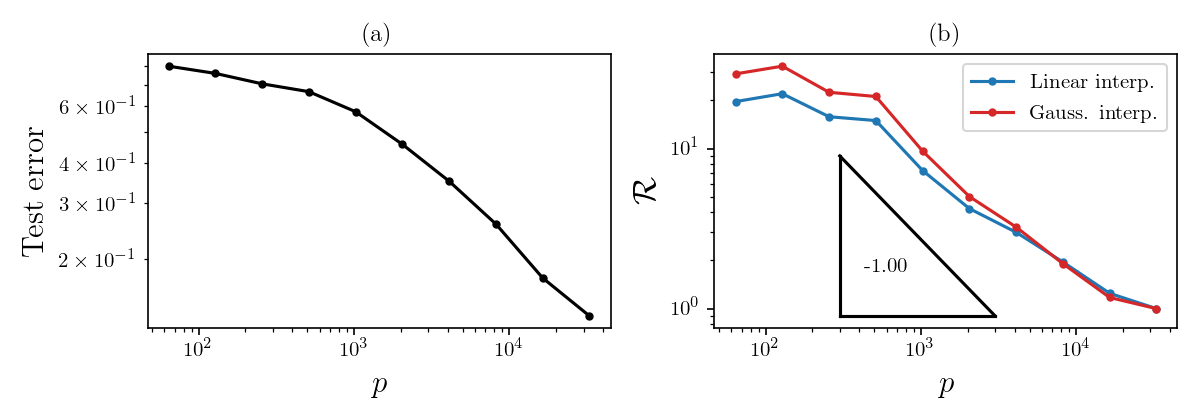

<ipython-input-66-933432d3bf0f>:32: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([pa, pb], labels=['Linear interp.', 'Gauss. interp.'])


In [66]:
%matplotlib notebook
fig = plt.figure(figsize=(8, 2.8), dpi=150)
pmax = df['ptr'].unique().max()

plt.subplot(121)
plt.title(f'(a)')
acc[dataset][cut][interp].apply(lambda a: 1 - a / 100).plot(marker='.', c='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$p$', fontsize=15)
plt.ylabel('Test error', fontsize=15)
plt.tight_layout()

plt.subplot(122)
for di, dataset in enumerate(['cifar10']):
    cut = 3 if 'mnist' in dataset else 5
    for interp in ['linear', 'gaussian']:

        cs = 'C0' if interp == 'linear' else 'C3'

        plt.title(f'(b)')
        R[dataset][cut][interp].apply(lambda a: a[0] / R[dataset][cut][interp][pmax][0]).plot(marker='.', c=cs)
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('$p$', fontsize=15)
        plt.tight_layout()
        
plt.ylabel(r'$\mathcal R$', fontsize=16)
triangle(300, 3e3, 9, slope=-1)
pa = plt.plot([], [], c='C0', label='Linear interp.')
pb = plt.plot([], [], c='C3', label='Gauss. interp.')
plt.legend([pa, pb], labels=['Linear interp.', 'Gauss. interp.'])
plt.tight_layout()

plt.savefig('./figures/cifar_effnet_compR.pdf', format='pdf')

# MobileNetv2

In [3]:
filename = 'mobilenetv2'

In [5]:
cuts = [3, 5, 15]
greyTrate = 1.2
interp = 'gaussian'
try:
    df = torch.load('./dataframes/mob-net-roughness-df.torch')
except FileNotFoundError:
    df = pd.DataFrame()

for interp in ['linear', 'gaussian']:
    for dataset in ['cifar10']:
        predicate = lambda a: a.dataset == dataset and a.ptr == 32768
        runs = load(prefix + filename, predicate=predicate)
        print(f'Loaded {len(runs)} runs')

        for cut in cuts:
        # interp = 'gaussian'
            if 'mnist' in dataset:
                ch = 1
                imgs = load_mnist(p=500, fashion= 'fashion' in dataset)
            else:
                ch = 3
                imgs = load_cifar(p=800)

            n = imgs.shape[-1]
            imgs = imgs.to('cpu')
            T1, T2 = temperature_range(n, cut)
            Ts = torch.logspace(math.log10(T1 / greyTrate), math.log10(T2 * greyTrate), 30)
            data = diffeo_imgs(imgs, cuts=[cut], Ts=Ts, interp=interp)
            imgs = data['imgs'].to(device)

            print(interp)

            ds, gs = relative_distance(identity, data['imgs'].to(device), data['cuts'][0]['diffeo'].to(device), data['cuts'][0]['normal'].to(device))
            df = df.append({
                'dataset': dataset,
                'cut': cut,
                'ptr': 50000,
                'Ts': data['cuts'][0]['temp'].numpy(),
                'layer': 'identity',
                'trained': 0,
                'interp': interp,
                'D': ds.to('cpu').numpy(),
                'G': gs.to('cpu').numpy(),
            }, ignore_index = True)

            for r in tqdm(runs):

                args = r['args']

                f = MobileNetV2(num_ch=ch)
                f = f.to(device)

                ### init ###
                try:
                    ds, gs = relative_distance(f, imgs, data['cuts'][0]['diffeo'].to(device), data['cuts'][0]['normal'].to(device))
                    df = df.append({
                        'dataset': dataset,
                        'seed_init': args.seed_init,
                        'ptr': args.ptr,
                        'cut': cut,
                        'Ts': data['cuts'][0]['temp'].numpy(),
                        'layer': 'f',
                        'trained': False,
                        'acc': r['best']['acc'],
                        'epoch': r['best']['epoch'],
                        'interp': interp,
                        'D': ds.to('cpu').numpy(),
                        'G': gs.to('cpu').numpy(),
                    }, ignore_index = True)

                    ### TRAINED ###
                    state = OrderedDict([(k[7:], r['best']['net'][k]) for k in r['best']['net']])
                    f.load_state_dict(state)
                    ds, gs = relative_distance(f, imgs, data['cuts'][0]['diffeo'].to(device), data['cuts'][0]['normal'].to(device))

                    df = df.append({
                        'dataset': dataset,
                        'seed_init': args.seed_init,
                        'ptr': args.ptr,
                        'cut': cut,
                        'Ts': data['cuts'][0]['temp'].numpy(),
                        'layer': 'f',
                        'trained': True,
                        'acc': r['best']['acc'],
                        'epoch': r['best']['epoch'],
                        'interp': interp,
                        'D': ds.to('cpu').numpy(),
                        'G': gs.to('cpu').numpy(),
                    }, ignore_index = True)
                except ZeroDivisionError:
                    continue


100%|██████████| 160/160 [00:01<00:00, 92.43it/s]


Loaded 16 runs
Files already downloaded and verified



linear



Files already downloaded and verified



linear



Files already downloaded and verified



linear



 46%|████▌     | 73/160 [00:00<00:00, 726.38it/s]


100%|██████████| 160/160 [00:00<00:00, 687.49it/s]


Loaded 16 runs
Files already downloaded and verified



gaussian



Files already downloaded and verified



gaussian



Files already downloaded and verified

gaussian


In [6]:
torch.save(df, './dataframes/mob-net-roughness-df.torch')

In [7]:
df = torch.load('./dataframes/mob-net-roughness-df.torch')

In [8]:
groups = ['dataset', 'cut', 'layer', 'trained', 'interp']

df['R'] = df['D'] / df['G']
D = df.groupby(groups)['D'].apply(logmean)
G = df.groupby(groups)['G'].apply(logmean)
R = df.groupby(groups)['R'].apply(logmean)
acc = df.groupby(groups)['acc'].apply(partial(logmean, vec=False))
epoch = df.groupby(groups)['epoch'].apply(partial(logmean, vec=False))

In [9]:
datasets = ['cifar10']

<IPython.core.display.Javascript object>


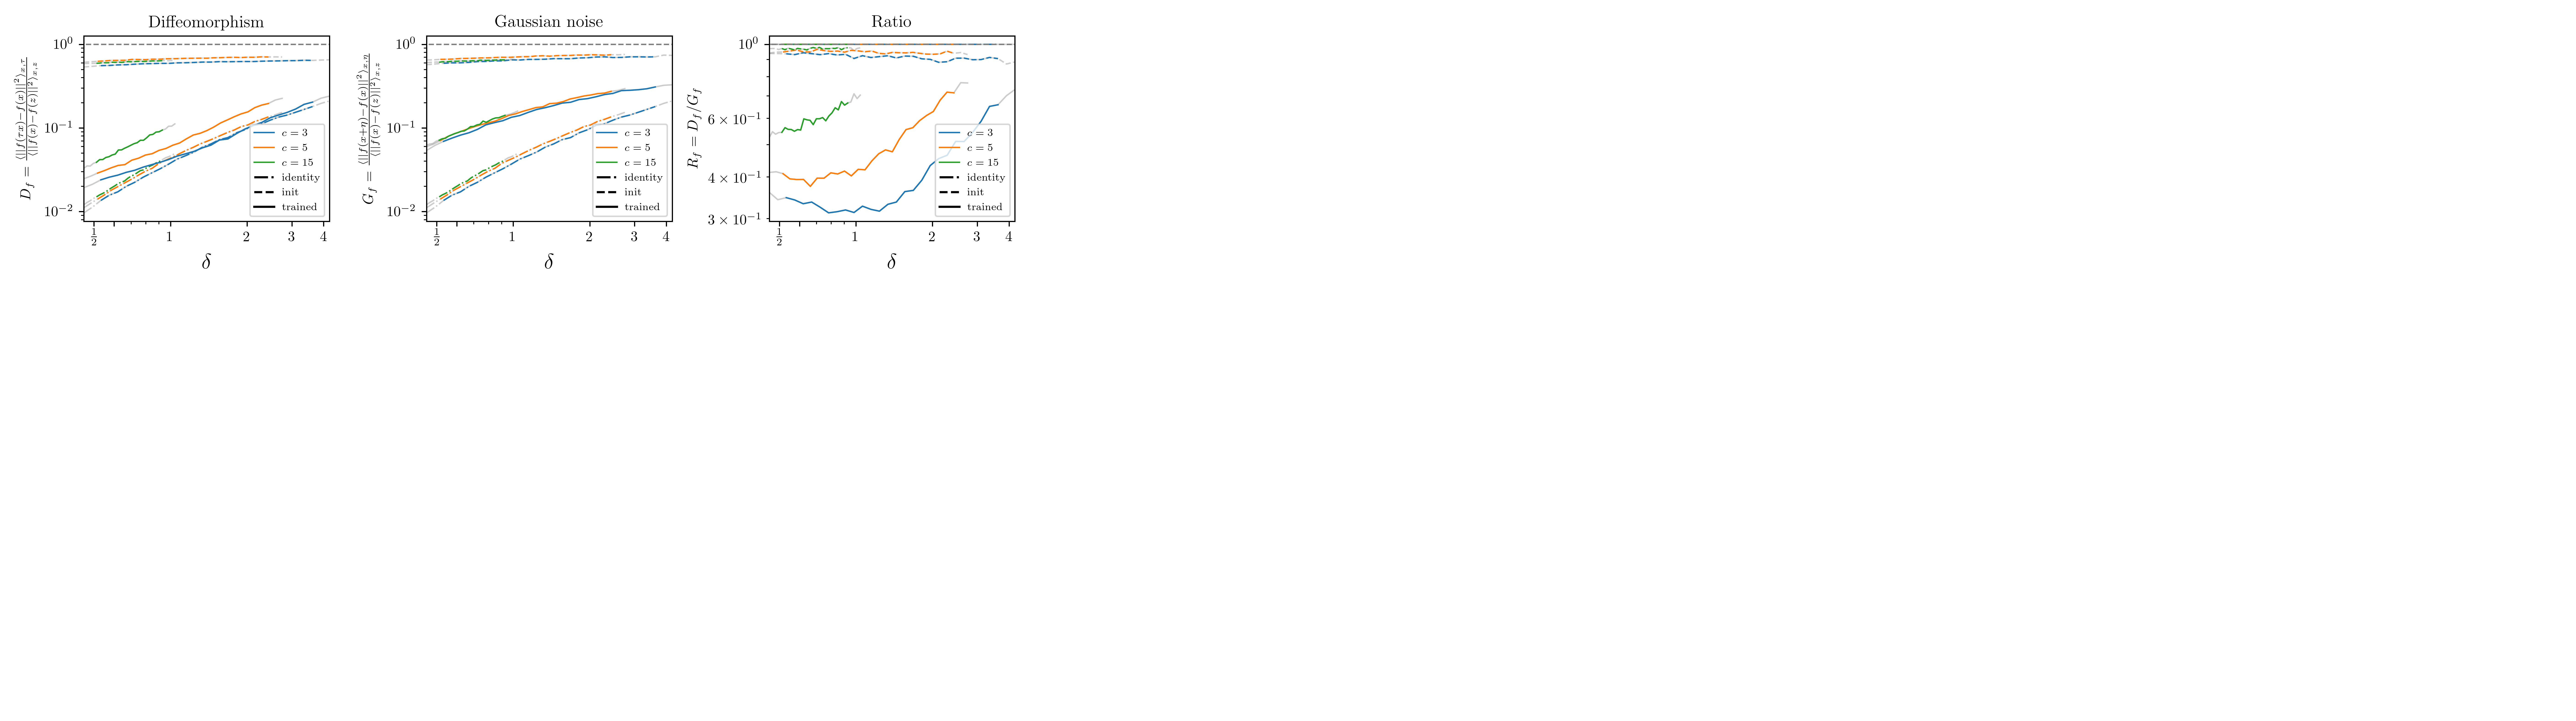

In [10]:
%matplotlib notebook
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(10, 2.8), dpi=180)
alpha = 0.4

interp = 'linear'

for (di, dataset), cut in product(enumerate(['cifar10']), cuts):
    T1, T2 = temperature_range(n, cut)
    Ts = torch.logspace(math.log10(T1 / greyTrate), math.log10(T2 * greyTrate), 30)
    m = (T1 <= Ts) & (Ts <= T2)
    delta = typical_displacement(Ts, cut)
    if cut == 3:
        d3 = copy.deepcopy(delta)
        
    ds, qs = D[dataset][cut]['identity'][0][interp], G[dataset][cut]['identity'][0][interp]

    plt.sca(ax1)
    plt.plot(delta, ds, '-.', color='gray', alpha = alpha, lw=1)
    plt.plot(delta[m], ds[m], '-.', lw=1)

    plt.sca(ax2)
    plt.plot(delta, qs, '-.', color='gray', alpha = alpha, lw=1)
    plt.plot(delta[m], qs[m], '-.', lw=1)

    plt.sca(ax3)
    plt.plot(delta, ds/qs, '-.', color='gray', alpha = alpha, lw=1)
    plt.plot(delta[m], (ds/qs)[m], '-.', lw=1)
        
        
for trained in [1, 0]:
    for ax in [ax1, ax2, ax3]:
        ax.set_prop_cycle(None)

    for cut in cuts:
        T1, T2 = temperature_range(n, cut)
        Ts = torch.logspace(math.log10(T1 / greyTrate), math.log10(T2 * greyTrate), 30)
        m = (T1 <= Ts) & (Ts <= T2)
        delta = typical_displacement(Ts, cut)

        ds, qs = D[dataset][cut]['f'][trained][interp], G[dataset][cut]['f'][trained][interp]
        
        if trained:
            label = f'$c = {cut}$'
        else:
            label = None
        
        plt.sca(ax1)
        plt.plot(delta, ds, '-' if trained else '--', color='gray', alpha = alpha, lw=1)
        plt.plot(delta[m], ds[m], '-' if trained else '--', label=label , lw=1)

        plt.sca(ax2)
        plt.plot(delta, qs, '-' if trained else '--', color='gray', alpha = alpha, lw=1)
        plt.plot(delta[m], qs[m], '-' if trained else '--', label=label , lw=1)

        plt.sca(ax3)
        plt.plot(delta, ds/qs, '-' if trained else '--', color='gray', alpha = alpha, lw=1)
        plt.plot(delta[m], (ds/qs)[m], '-' if trained else '--', label=label, lw=1)


for ax in [ax1, ax2, ax3]:
    plt.sca(ax)
    plt.plot([], [], 'k-.', label='identity')
    plt.plot([], [], 'k--', label='init')
    plt.plot([], [], 'k-', label='trained')

    plt.plot(plt.xlim(), [1, 1], '--', color='gray', linewidth=1)

    plt.legend(fontsize=7)
    plt.xscale('log')
    plt.yscale('log')

    plt.xlim(d3[0], d3[-1])
    plt.xlabel(r'$\delta$', fontsize=15)

    plt.xticks([0.5, 0.6, 1, 2, 3, 4], [r'$\frac{1}{2}$', '', 1, 2, 3, 4])
    
plt.sca(ax1)    
plt.ylabel(r'$D_f = \frac{\langle ||f(\tau x) - f(x)||^2\rangle_{x, \tau}}{\langle ||f(x) - f(z)||^2\rangle_{x, z}}$')
plt.title('Diffeomorphism')
plt.sca(ax2)
plt.ylabel(r'$    G_f = \frac{\langle ||f(x + \eta) - f(x)||^2\rangle_{x, \eta}}{\langle ||f(x) - f(z)||^2\rangle_{x, z}}$')
plt.title('Gaussian noise')
plt.sca(ax3)
plt.ylabel(r'$R_f = D_f / G_f$')
plt.title('Ratio')


# plt.sca(ax1)
# triangle(0.5, 5, 2e-4, slope=1)
# plt.sca(ax2)
# triangle(0.5, 5, 1e-4, slope=2)

for ax in [ax1, ax2]:
    plt.sca(ax)
#     plt.ylim(4e-3, 1.01)
    
plt.tight_layout()
# plt.suptitle('EfficientNetB0 on CIFAR10', y=.99)
# plt.savefig('./figures/cifar_effnet_roughness.pdf', format='pdf')

<IPython.core.display.Javascript object>


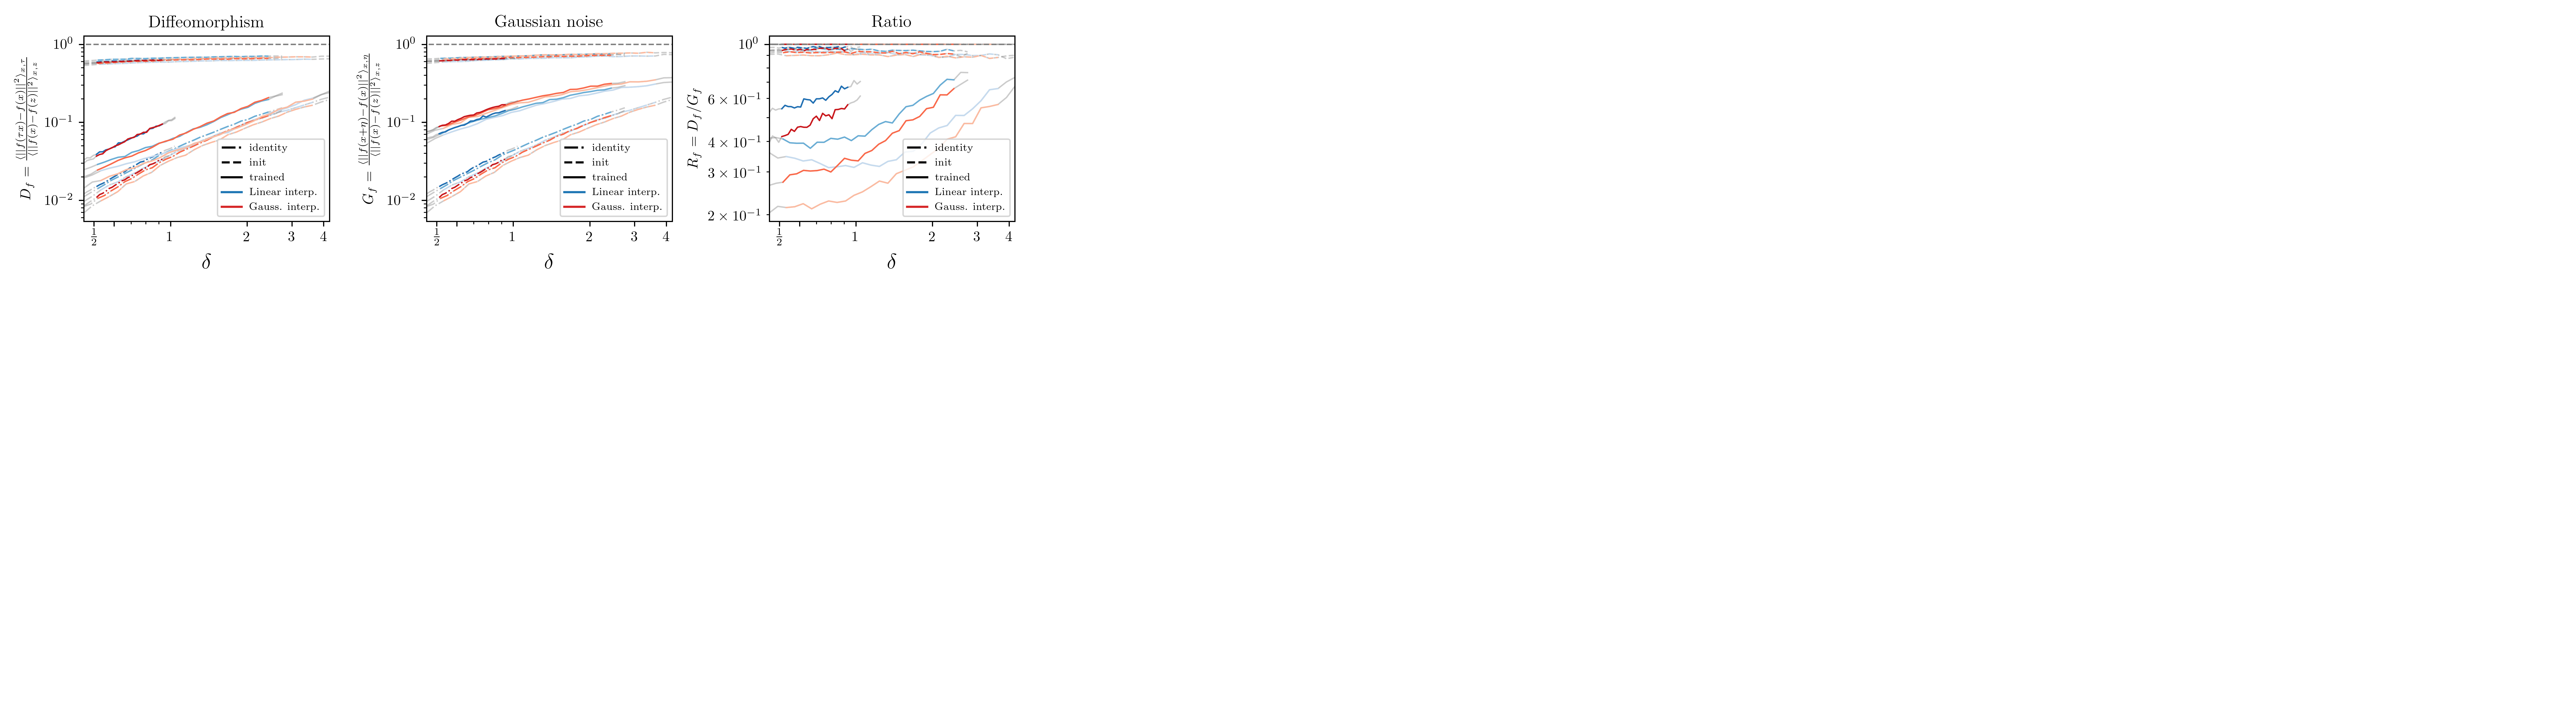

<ipython-input-11-de1ddfc94c22>:73: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([pa, pb], labels=['Linear interp.', 'Gauss. interp.'])
<ipython-input-11-de1ddfc94c22>:73: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([pa, pb], labels=['Linear interp.', 'Gauss. interp.'])
<ipython-input-11-de1ddfc94c22>:73: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([pa, pb], labels=['Linear interp.', 'Gauss. interp.'])


In [11]:
%matplotlib notebook
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(10, 2.8), dpi=180)
alpha = 0.4

nc = 3 # Number of colors
bcs = [plt.get_cmap('Blues')((i+1)/(nc+1)) for i in range(nc)]
rcs = [plt.get_cmap('Reds')((i+1)/(nc+1)) for i in range(nc)]

for interp in ['linear', 'gaussian']:
    
    cs = bcs if interp == 'linear' else rcs
    
    for (di, dataset), (ci, cut) in product(enumerate(['cifar10']), enumerate(cuts)):
        T1, T2 = temperature_range(n, cut)
        Ts = torch.logspace(math.log10(T1 / greyTrate), math.log10(T2 * greyTrate), 30)
        m = (T1 <= Ts) & (Ts <= T2)
        delta = typical_displacement(Ts, cut)
        if cut == 3:
            d3 = copy.deepcopy(delta)

        ds, qs = D[dataset][cut]['identity'][0][interp], G[dataset][cut]['identity'][0][interp]

        plt.sca(ax1)
        plt.plot(delta, ds, '-.', color='gray', alpha = alpha, lw=1)
        plt.plot(delta[m], ds[m], '-.', lw=1, c=cs[ci])

        plt.sca(ax2)
        plt.plot(delta, qs, '-.', color='gray', alpha = alpha, lw=1)
        plt.plot(delta[m], qs[m], '-.', lw=1, c=cs[ci])

        plt.sca(ax3)
        plt.plot(delta, ds/qs, '-.', color='gray', alpha = alpha, lw=1)
        plt.plot(delta[m], (ds/qs)[m], '-.', lw=1, c=cs[ci])


    for trained in [1, 0]:
        for ax in [ax1, ax2, ax3]:
            ax.set_prop_cycle(None)

        for ci, cut in enumerate(cuts):
            T1, T2 = temperature_range(n, cut)
            Ts = torch.logspace(math.log10(T1 / greyTrate), math.log10(T2 * greyTrate), 30)
            m = (T1 <= Ts) & (Ts <= T2)
            delta = typical_displacement(Ts, cut)

            ds, qs = D[dataset][cut]['f'][trained][interp], G[dataset][cut]['f'][trained][interp]

            if 0:
                label = f'$c = {cut}$'
            else:
                label = None

            plt.sca(ax1)
            plt.plot(delta, ds, '-' if trained else '--', color='gray', alpha = alpha, lw=1)
            plt.plot(delta[m], ds[m], '-' if trained else '--', label=label , lw=1, c=cs[ci])

            plt.sca(ax2)
            plt.plot(delta, qs, '-' if trained else '--', color='gray', alpha = alpha, lw=1)
            plt.plot(delta[m], qs[m], '-' if trained else '--', label=label , lw=1, c=cs[ci])

            plt.sca(ax3)
            plt.plot(delta, ds/qs, '-' if trained else '--', color='gray', alpha = alpha, lw=1)
            plt.plot(delta[m], (ds/qs)[m], '-' if trained else '--', label=label, lw=1, c=cs[ci])


for ax in [ax1, ax2, ax3]:
    plt.sca(ax)
    plt.plot([], [], 'k-.', label='identity')
    plt.plot([], [], 'k--', label='init')
    plt.plot([], [], 'k-', label='trained')
    pa = plt.plot([], [], c='C0', label='Linear interp.')
    pb = plt.plot([], [], c='C3', label='Gauss. interp.')
    plt.legend([pa, pb], labels=['Linear interp.', 'Gauss. interp.'])
    plt.plot(plt.xlim(), [1, 1], '--', color='gray', linewidth=1)

    plt.legend(fontsize=7)
    plt.xscale('log')
    plt.yscale('log')

    plt.xlim(d3[0], d3[-1])
    plt.xlabel(r'$\delta$', fontsize=15)

    plt.xticks([0.5, 0.6, 1, 2, 3, 4], [r'$\frac{1}{2}$', '', 1, 2, 3, 4])
    
plt.sca(ax1)    
plt.ylabel(r'$D_f = \frac{\langle ||f(\tau x) - f(x)||^2\rangle_{x, \tau}}{\langle ||f(x) - f(z)||^2\rangle_{x, z}}$')
plt.title('Diffeomorphism')
plt.sca(ax2)
plt.ylabel(r'$    G_f = \frac{\langle ||f(x + \eta) - f(x)||^2\rangle_{x, \eta}}{\langle ||f(x) - f(z)||^2\rangle_{x, z}}$')
plt.title('Gaussian noise')
plt.sca(ax3)
plt.ylabel(r'$R_f = D_f / G_f$')
plt.title('Ratio')


# plt.sca(ax1)
# triangle(0.5, 5, 2e-4, slope=1)
# plt.sca(ax2)
# triangle(0.5, 5, 1e-4, slope=2)

for ax in [ax1, ax2]:
    plt.sca(ax)
#     plt.ylim(4e-3, 1.01)
    
plt.tight_layout()
# plt.suptitle('EfficientNetB0 on CIFAR10', y=.99)
plt.savefig('./figures/cifar_mobnet_roughness_interp.pdf', format='pdf')

$\mathcal R$

In [21]:
try:
    df = torch.load('./dataframes/mob-net-df-p.torch')
except:
    df = pd.DataFrame()
    
for dataset in ['cifar10']:
    predicate = lambda a: a.dataset == dataset
    runs = load(prefix + filename, predicate=predicate)
    print(f'Loaded {len(runs)} runs')

    for interp in ['linear', 'gaussian']:
    # interp = 'gaussian'
        if 'mnist' in dataset:
            cut = 3
            ch = 1
            imgs = load_mnist(p=500, fashion= 'fashion' in dataset)
        else:
            cut = 5
            ch = 3
            imgs = load_cifar(p=500)
            
        n = imgs.shape[-1]
        imgs = imgs.to('cpu')
        T1, T2 = temperature_range(n, cut)
        Ts = typical_temperature(delta=torch.ones(1,), cut=cut)
        data = diffeo_imgs(imgs, cuts=[cut], Ts=Ts, interp=interp)
        imgs = data['imgs'].to(device)

        print(interp)

        for r in tqdm(runs):

            args = r['args']

            f = MobileNetV2(num_ch=ch)
            f = f.to(device)
            state = OrderedDict([(k[7:], r['best']['net'][k]) for k in r['best']['net']])
            f.load_state_dict(state)

            rs = computeR(f, imgs, data['cuts'][0]['diffeo'].to(device), data['cuts'][0]['normal'].to(device))

            df = df.append({
                'dataset': args.dataset,
                'seed_init': args.seed_init,
                'ptr': args.ptr,
                'cut': cut,
                'Ts': data['cuts'][0]['temp'].numpy(),
                'layer': 'f',
                'trained': True,
                'acc': r['best']['acc'],
                'epoch': r['best']['epoch'],
                'interp': interp,
                'R': rs.to('cpu').numpy(),
            }, ignore_index = True)






100%|██████████| 160/160 [00:00<00:00, 121398.09it/s]A


Loaded 160 runs
Files already downloaded and verified



linear



Files already downloaded and verified



gaussian


In [22]:
torch.save(df, './dataframes/mob-net-df-p.torch')

In [23]:
groups = ['dataset', 'cut', 'interp', 'ptr']
R = df.groupby(groups)['R'].apply(logmean)
acc = df.groupby(groups)['acc'].apply(partial(logmean, vec=False))
epoch = df.groupby(groups)['epoch'].apply(partial(logmean, vec=False))

In [26]:
torch.save({
    'R': R,
    'acc': acc
}, './dataframes/mob-net-R.torch')

In [27]:
dR = torch.load('./dataframes/mob-net-R.torch')
R = dR['R']

<IPython.core.display.Javascript object>


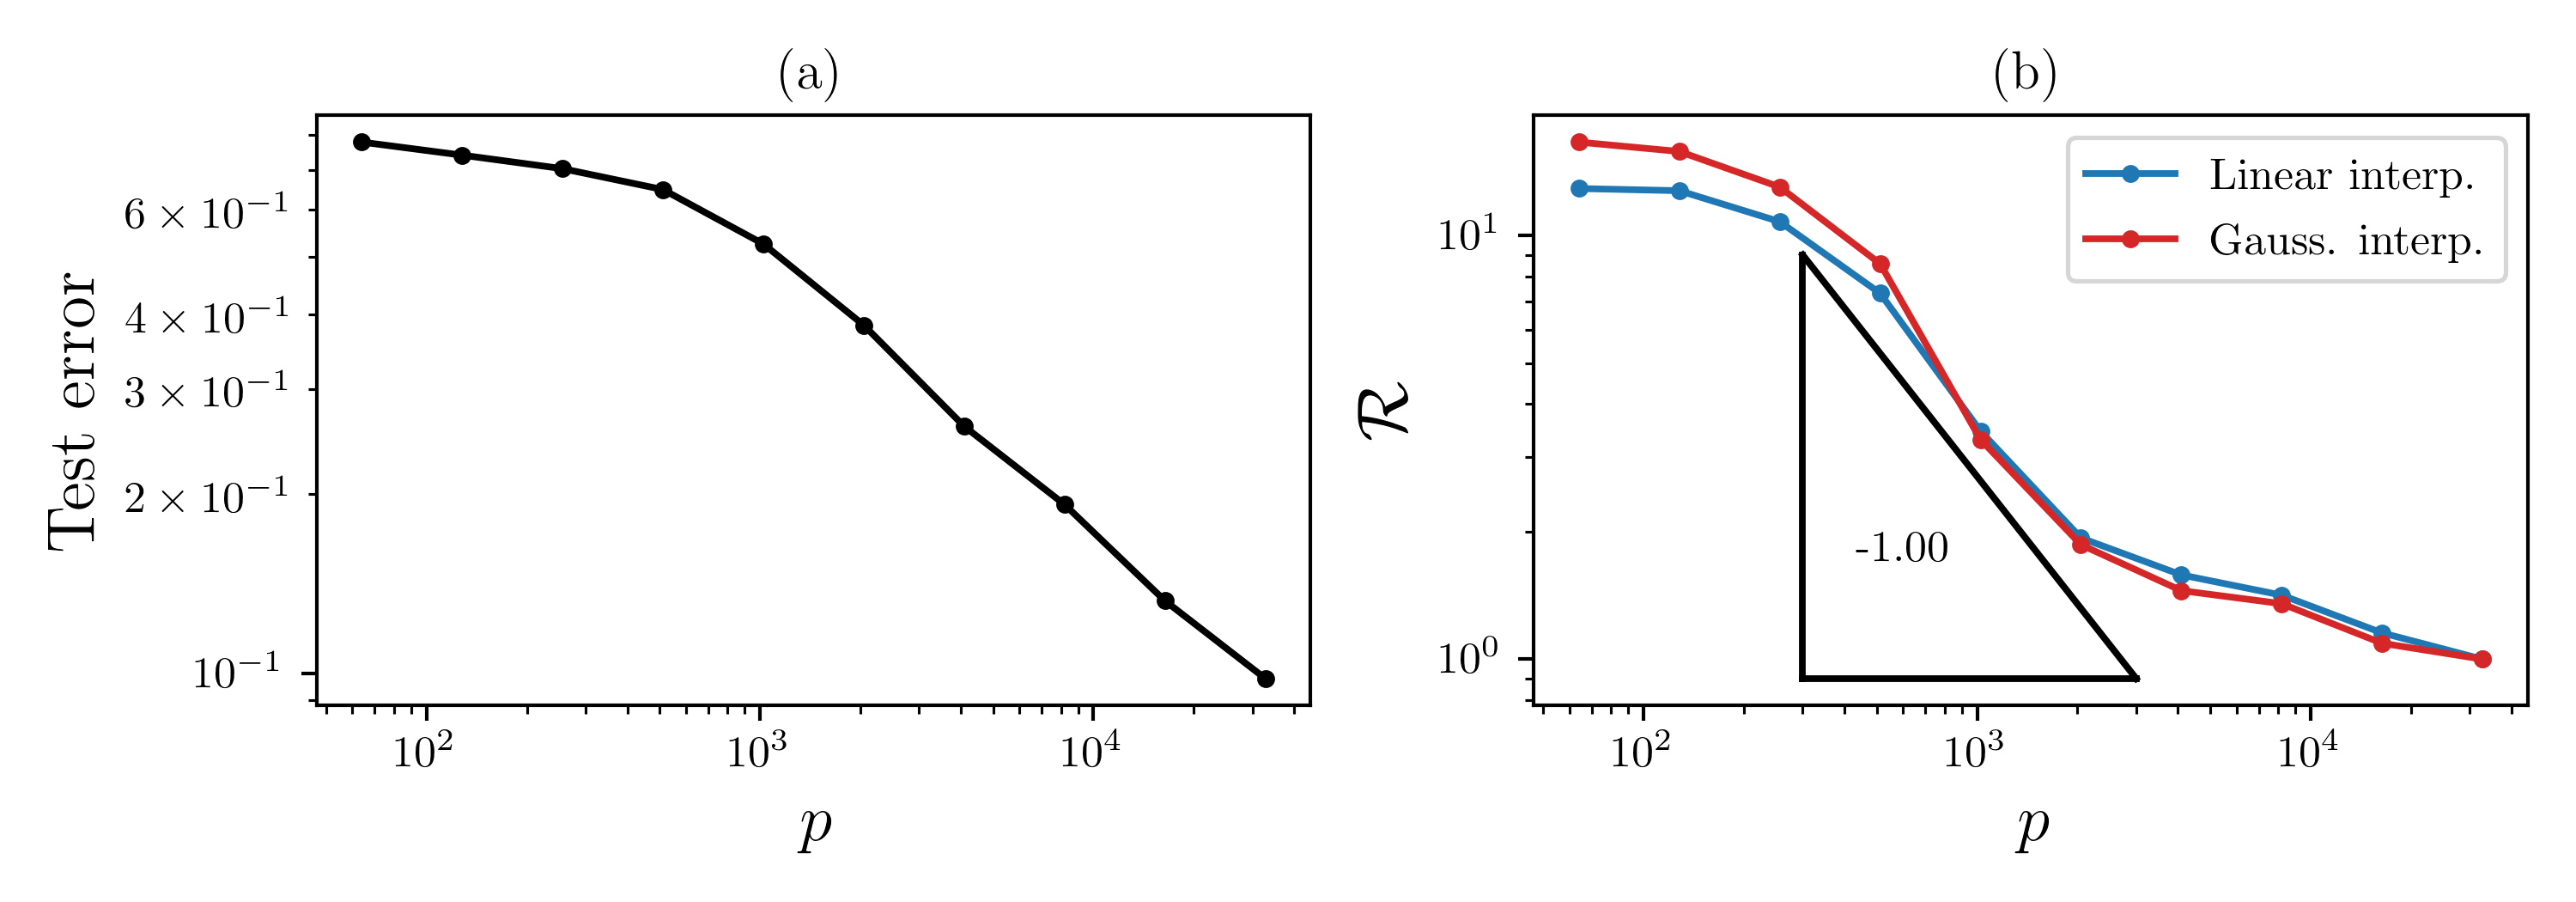

<ipython-input-28-f77569543779>:32: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([pa, pb], labels=['Linear interp.', 'Gauss. interp.'])


In [28]:
%matplotlib notebook
fig = plt.figure(figsize=(8, 2.8), dpi=150)
pmax = df['ptr'].unique().max()

plt.subplot(121)
plt.title(f'(a)')
acc[dataset][cut][interp].apply(lambda a: 1 - a / 100).plot(marker='.', c='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$p$', fontsize=15)
plt.ylabel('Test error', fontsize=15)
plt.tight_layout()

plt.subplot(122)
for di, dataset in enumerate(['cifar10']):
    cut = 3 if 'mnist' in dataset else 5
    for interp in ['linear', 'gaussian']:

        cs = 'C0' if interp == 'linear' else 'C3'

        plt.title(f'(b)')
        R[dataset][cut][interp].apply(lambda a: a[0] / R[dataset][cut][interp][pmax][0]).plot(marker='.', c=cs)
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('$p$', fontsize=15)
        plt.tight_layout()
        
plt.ylabel(r'$\mathcal R$', fontsize=16)
triangle(300, 3e3, 9, slope=-1)
pa = plt.plot([], [], c='C0', label='Linear interp.')
pb = plt.plot([], [], c='C3', label='Gauss. interp.')
plt.legend([pa, pb], labels=['Linear interp.', 'Gauss. interp.'])
plt.tight_layout()

plt.savefig('./figures/cifar_mobnet_compR.pdf', format='pdf')